In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
import sys
import glob
import math
import time
import os

def validate_contour(contour, img, aspect_ratio_range, area_range):
    rect = cv2.minAreaRect(contour)
    img_width = img.shape[1]
    img_height = img.shape[0]
    box = cv2.boxPoints(rect) 
    box = np.int0(box)

    X = rect[0][0]
    Y = rect[0][1]
    angle = rect[2] 
    width = rect[1][0]
    height = rect[1][1]

    angle = (angle + 180) if width < height else (angle + 90)

    output=False
    
    if (width > 0 and height > 0) and ((width < img_width/2.0) and (height < img_width/2.0)):
        aspect_ratio = float(width)/height if width > height else float(height)/width
        if (aspect_ratio >= aspect_ratio_range[0] and aspect_ratio <= aspect_ratio_range[1]):
            if((height*width > area_range[0]) and (height*width < area_range[1])):

                box_copy = list(box)
                point = box_copy[0]
                del(box_copy[0])
                dists = [((p[0]-point[0])**2 + (p[1]-point[1])**2) for p in box_copy]
                sorted_dists = sorted(dists)
                opposite_point = box_copy[dists.index(sorted_dists[1])]
                tmp_angle = 90

                if abs(point[0]-opposite_point[0]) > 0:
                    tmp_angle = abs(float(point[1]-opposite_point[1]))/abs(point[0]-opposite_point[0])
                    tmp_angle = rad_to_deg(math.atan(tmp_angle))

                if tmp_angle <= 45:
                    output = True
    return output

def deg_to_rad(angle):
    return angle*np.pi/180.0

def rad_to_deg(angle):
        return angle*180/np.pi

def enhance(img):
    kernel = np.array([[-1,0,1],[-2,0,2],[1,0,1]])
    return cv2.filter2D(img, -1, kernel)

def process_image(name, debug, **options):

    se_shape = (16,4)

    if options.get('type') == 'rect':
        se_shape = (17,4)

    elif options.get('type') == 'square':
        se_shape = (7,6)

    if options.get('blur') == True:
        blur = True
    else:
        blur = False
        
    raw_image = cv2.imread(name,1)
    input_image = np.copy(raw_image)

    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    gray = enhance(gray)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    gray = cv2.Sobel(gray, -1, 1, 0)
    h,sobel = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    se = cv2.getStructuringElement(cv2.MORPH_RECT, se_shape)
    gray = cv2.morphologyEx(sobel, cv2.MORPH_CLOSE, se)
    ed_img = np.copy(gray)

    _,contours,_=cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    font = cv2.FONT_HERSHEY_SIMPLEX

    for contour in contours:
        aspect_ratio_range = (2.2, 12)
        area_range = (500, 18000)

        if options.get('type') == 'rect':
            aspect_ratio_range = (2.2, 12)
            area_range = (500, 18000)

        elif options.get('type') == 'square':
            aspect_ratio_range = (1, 2)
            area_range = (300, 8000)

        if validate_contour(contour, gray, aspect_ratio_range, area_range):
            rect = cv2.minAreaRect(contour)  
            box = cv2.boxPoints(rect) 
            box = np.int0(box)  
            Xs = [i[0] for i in box]
            Ys = [i[1] for i in box]
            x1 = min(Xs)
            x2 = max(Xs)
            y1 = min(Ys)
            y2 = max(Ys)

            angle = rect[2]
            if angle < -45:
                angle += 90 

            W = rect[1][0]
            H = rect[1][1]
            aspect_ratio = float(W)/H if W > H else float(H)/W

            center = ((x1+x2)/2,(y1+y2)/2)
            size = (x2-x1, y2-y1)
            M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0);
            tmp = cv2.getRectSubPix(ed_img, size, center)
            tmp = cv2.warpAffine(tmp, M, size)
            TmpW = H if H > W else W
            TmpH = H if H < W else W
            tmp = cv2.getRectSubPix(tmp, (int(TmpW),int(TmpH)), (size[0]/2, size[1]/2))
            __,tmp = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

            white_pixels = 0

            for x in range(tmp.shape[0]):
                for y in range(tmp.shape[1]):
                    if tmp[x][y] == 255:
                        white_pixels += 1

            edge_density = float(white_pixels)/(tmp.shape[0]*tmp.shape[1])

            tmp = cv2.getRectSubPix(raw_image, size, center)
            tmp = cv2.warpAffine(tmp, M, size)
            TmpW = H if H > W else W
            TmpH = H if H < W else W
            tmp = cv2.getRectSubPix(tmp, (int(TmpW),int(TmpH)), (size[0]/2, size[1]/2))

            if edge_density > 0.5:
                if (blur):
                    tmpImage = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
                    tmpImage = cv2.blur(tmpImage,(29,29),0)
                    input_image[y1:y1+tmpImage.shape[0],x1:x1+tmpImage.shape[1]] = tmpImage
                else:    
                    cv2.drawContours(input_image, [box], 0, (0,255,255),2)
                
    return input_image

Time taken: 144 ms


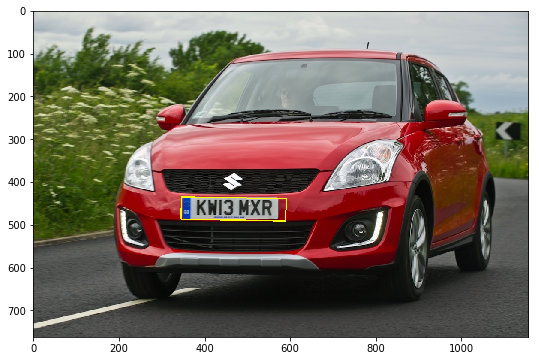

In [105]:
t1 = time.time()
# running with detection instead of blurring
o1 = process_image('1.jpg', 0, type='rect', blur=False)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(o1, cv2.COLOR_BGR2RGB))

print("Time taken: %d ms"%((time.time()-t1)*1000))

Time taken: 144 ms


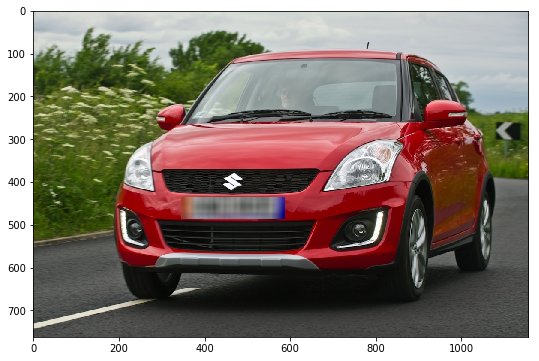

In [106]:
t1 = time.time()
o1 = process_image('1.jpg', 0, type='rect', blur=True)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(o1, cv2.COLOR_BGR2RGB))
print("Time taken: %d ms"%((time.time()-t1)*1000))

Time taken: 64 ms


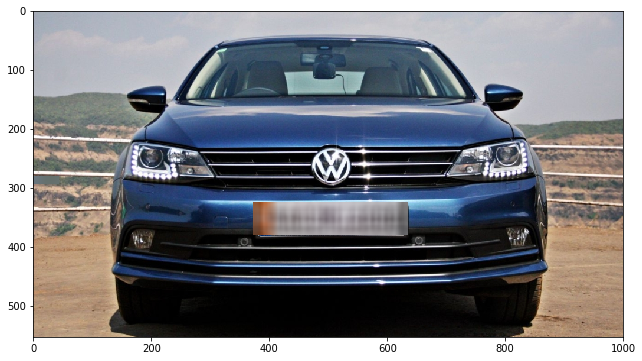

In [107]:
t1 = time.time()
o1 = process_image('2.jpg', 0, type='rect', blur=True)
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(o1, cv2.COLOR_BGR2RGB))
print("Time taken: %d ms"%((time.time()-t1)*1000))